# üìä Estimaci√≥n de Tr√°fico Web a partir de Tranco Rank

En este notebook, analizaremos la relaci√≥n entre el tr√°fico web (`web_traffic`) y el ranking de Tranco (`tranco_rank`).  
Entrenaremos un modelo de regresi√≥n para predecir `web_traffic` en sitios donde no tenemos datos directos.


In [38]:
# üìå Importamos las librer√≠as necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from xgboost import XGBRegressor

In [39]:
df = pd.read_csv('../Data/train_with_tranco.csv')
df.head()

url  length_url  \
0  https://help.ubuntu.com/community/Mobile%20Bro...          80   
1                     http://www.voipoid.com/telekom          30   
2  http://usbank-link-mupyndtfft---com.illmickels...          58   
3     http://www.flaticon.com/free-icons/parking_403          46   
4                             https://www.hivos.org/          22   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               15   0        2           0      0      0       0      0  ...   
1               15   0        2           0      0      0       0      0  ...   
2               50   0        2           5      0      0       0      0  ...   
3               16   0        2           1      0      0       0      0  ...   
4               13   0        2           0      0      0       0      0  ...   

   whois_registered_domain  domain_registration_length  domain_age  \
0                        0                         676        5897   
1                        0                         206         889   
2                        0                         372        1454   
3                        0                         288        2633   
4                        0                         110          -1   

   web_traffic  dns_record  google_index  page_rank      status  \
0         2688           0             1          7  legitimate   
1            0           0             1          1    phishing   
2            0           0             1          0    phishing   
3          827           0             1          7  legitimate   
4       442024           0             0          5  legitimate   

                  domain  tranco_rank  
0             ubuntu.com          232  
1            voipoid.com      1500000  
2  illmickelsonbeats.com      1500000  
3           flaticon.com         2663  
4              hivos.org       296406  

[5 rows x 91 columns]

## üîç An√°lisis Inicial
Revisamos la cantidad de datos disponibles y verificamos la cobertura del ranking de Tranco.


In [40]:
# üìä Contar registros con y sin Tranco Rank v√°lido
num_total = df.shape[0]
num_valid = df[df["tranco_rank"] != 1_500_000].shape[0]
num_invalid = df[df["tranco_rank"] == 1_500_000].shape[0]

webtraffic_valid = df[df["web_traffic"] != 0]
webtraffic_invalid = df[df["web_traffic"] == 0]

print(f"Total de registros: {num_total}")
print(f"Con Tranco Rank v√°lido: {num_valid} ({(num_valid / num_total) * 100:.2f}%)")
print(f"Sin Tranco Rank (1,500,000 asignado): {num_invalid} ({(num_invalid / num_total) * 100:.2f}%)")

print(f"Registros con tr√°fico web distinto de 0: {webtraffic_valid.shape[0]}")
print(f"Registros con tr√°fico web igual a 0: {webtraffic_invalid.shape[0]}")



Total de registros: 10858
Con Tranco Rank v√°lido: 5412 (49.84%)
Sin Tranco Rank (1,500,000 asignado): 5446 (50.16%)
Registros con tr√°fico web distinto de 0: 6639
Registros con tr√°fico web igual a 0: 4219


### üìâ Visualizaci√≥n de Tranco Rank vs. Web Traffic
Vamos a analizar gr√°ficamente la relaci√≥n entre `tranco_rank` y `web_traffic`.
Aplicamos transformaci√≥n logaritmica para mejorar la linealidad y escala.

# üõ† 2. Limpieza y Transformaci√≥n de Datos

El dataset contiene columnas como web_traffic y tranco_rank. Aplicaremos transformaciones logar√≠tmicas para mejorar la linealidad y eliminar valores at√≠picos.


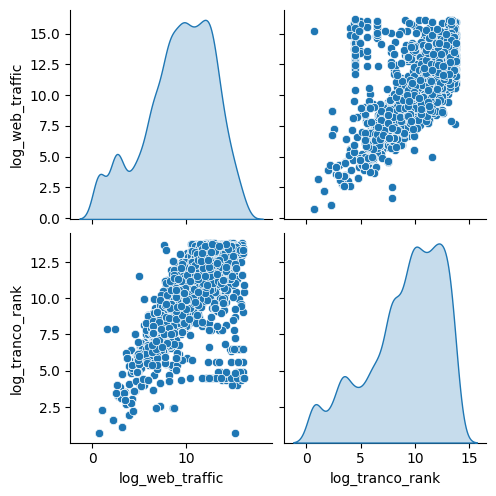

In [41]:
# Eliminamos valores nulos
df = df.dropna(subset=["web_traffic", "tranco_rank"])

# Eliminamos valores inv√°lidos (ranks menores o iguales a 0)
df = df[df["tranco_rank"] > 0]

# Eliminamos valores falsos (ranks iguales a 1,500,000)
df = df[df["tranco_rank"] != 1_500_000]

# Eliminamos valores inv√°lidos (tr√°fico web menor a 0)
df = df[df["web_traffic"] > 0]

# Aplicamos transformaci√≥n logar√≠tmica
df["log_web_traffic"] = np.log1p(df["web_traffic"])
df["log_tranco_rank"] = np.log1p(df["tranco_rank"])

df['tranco_rank_log'] = np.log1p(df['tranco_rank'])
df['web_traffic_bc'], _ = boxcox(df['web_traffic'] + 1)

# üîç Visualizamos la distribuci√≥n de los datos
sns.pairplot(df[["log_web_traffic", "log_tranco_rank"]], diag_kind='kde')
plt.show()

In [42]:
df['tranco_inverse'] = 1 / df['tranco_rank']
df['tranco_sqrt'] = np.sqrt(df['tranco_rank'])
df['tranco_percentile'] = pd.qcut(df['tranco_rank'], q=10, labels=False)

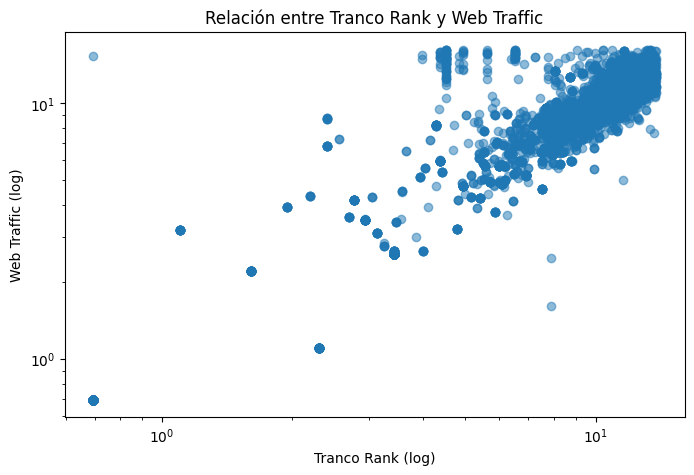

In [43]:
# üìà Scatter plot de la relaci√≥n
plt.figure(figsize=(8, 5))
plt.scatter(df["log_tranco_rank"], df["log_web_traffic"], alpha=0.5)
plt.xlabel("Tranco Rank (log)")
plt.ylabel("Web Traffic (log)")
plt.title("Relaci√≥n entre Tranco Rank y Web Traffic")
plt.xscale("log")
plt.yscale("log")
plt.show()

üìù An√°lisis: Se observa una relaci√≥n lineal clara entre el ranking de Tranco y el tr√°fico web. Sin embargo, hay cierta dispersi√≥n, lo que sugiere que podr√≠amos necesitar un modelo m√°s complejo que una regresi√≥n lineal simple.

# ‚úÇÔ∏è 4. Divisi√≥n del dataset en entrenamiento y prueba

In [44]:
# Dividimos en conjunto de entrenamiento y prueba
X = df[["log_tranco_rank"]]
y = df["log_web_traffic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# üìà 5. Modelos a Probar

Vamos a probar varios modelos y comparar sus rendimientos:

1. Regresi√≥n Lineal (modelo base)
2. Regresi√≥n Polin√≥mica (para capturar relaciones no lineales)
3. Random Forest Regressor (modelo no param√©trico)
4. XGBoost (modelo avanzado de boosting)

# üîπ 5.1 Regresi√≥n Lineal



üìä Regresi√≥n Lineal:
RMSE: 2.054485149025931
R¬≤: 0.6616293419136907


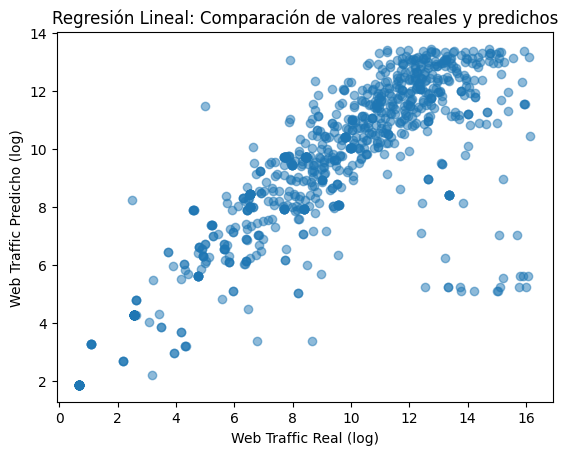

In [45]:
# Entrenamos el modelo de regresi√≥n lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicci√≥n
y_pred_lr = lr.predict(X_test)

# Evaluaci√≥n del modelo
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("üìä Regresi√≥n Lineal:")
print(f"RMSE: {rmse_lr}")
print(f"R¬≤: {r2_lr}")

# Visualizaci√≥n
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Regresi√≥n Lineal: Comparaci√≥n de valores reales y predichos")
plt.show()


üìù An√°lisis: La regresi√≥n lineal nos da un punto de referencia, pero dado que la relaci√≥n entre Tranco Rank y Web Traffic no es completamente lineal, podr√≠a no ser el mejor modelo.

# üîπ 5.2 Regresi√≥n Polin√≥mica (Grado 2)

üìä Regresi√≥n Polin√≥mica:
RMSE: 2.0543913604723842
R¬≤: 0.6616602348799712


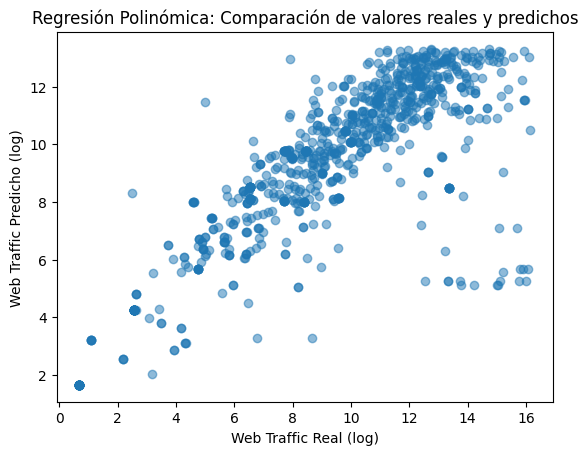

In [46]:
# Aplicamos transformaci√≥n polin√≥mica
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Entrenamos el modelo de regresi√≥n polin√≥mica
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

# Predicci√≥n
y_pred_poly = lr_poly.predict(X_test_poly)

# Evaluaci√≥n del modelo
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print("üìä Regresi√≥n Polin√≥mica:")
print(f"RMSE: {rmse_poly}")
print(f"R¬≤: {r2_poly}")

# Visualizaci√≥n
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Regresi√≥n Polin√≥mica: Comparaci√≥n de valores reales y predichos")
plt.show()


# üîπ 5.3 Random Forest Regressor

üå≤ Random Forest:
RMSE: 1.3700931610438918
R¬≤: 0.8495171940986079


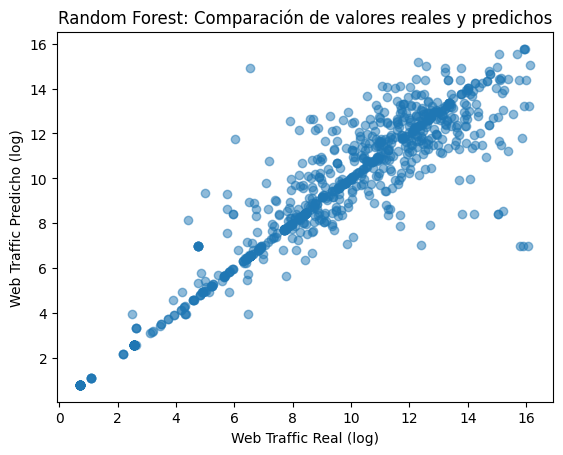

In [47]:
# Entrenamos un modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicci√≥n
y_pred_rf = rf.predict(X_test)

# Evaluaci√≥n del modelo
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("üå≤ Random Forest:")
print(f"RMSE: {rmse_rf}")
print(f"R¬≤: {r2_rf}")

# Visualizaci√≥n
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Random Forest: Comparaci√≥n de valores reales y predichos")
plt.show()


# üîπ 5.4 XGBoost Regressor

üöÄ XGBoost:
RMSE: 1.5811870234103167
R¬≤: 0.7995744119787691


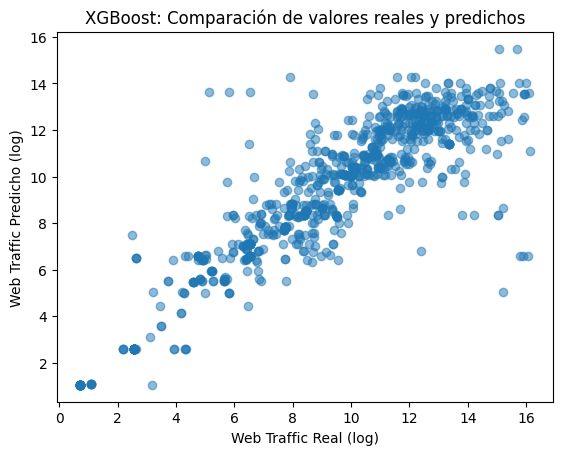

In [48]:
# Entrenamos un modelo XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predicci√≥n
y_pred_xgb = xgb_model.predict(X_test)

# Evaluaci√≥n del modelo
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("üöÄ XGBoost:")
print(f"RMSE: {rmse_xgb}")
print(f"R¬≤: {r2_xgb}")

# Visualizaci√≥n
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("XGBoost: Comparaci√≥n de valores reales y predichos")
plt.show()


In [49]:
import sys
import os

# üìå Obtener la ruta del notebook en ejecuci√≥n
notebook_dir = os.getcwd()

# üìå Agregar la ruta del directorio ra√≠z al sys.path para que detecte `utils/`
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "..")))

# üìå Importar la clase corregida desde utils/transformers.py
from utils.transformers import SklearnXGBRegressor as XGBWrapper


In [50]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



# Definir estimadores base
estimadores = [
    ('rf', RandomForestRegressor(n_jobs=-1, random_state=42)),
    ('xgb', XGBWrapper(n_jobs=-1, random_state=42, max_depth=3, n_estimators=100, learning_rate=0.1))  # Correcto
]


# Crear el modelo de Stacking
stacking = StackingRegressor(
    estimators=estimadores,
    final_estimator=LinearRegression(),
    passthrough=False,
    n_jobs=-1
)

# Entrenar modelo
stacking.fit(X_train, y_train)

print("‚úÖ Modelo StackingRegressor entrenado con √©xito en scikit-learn 1.6.1.")


‚úÖ Modelo StackingRegressor entrenado con √©xito en scikit-learn 1.6.1.


üöÄ XGBoost:
RMSE: 1.3435695819761786
R¬≤: 0.8552871790771984


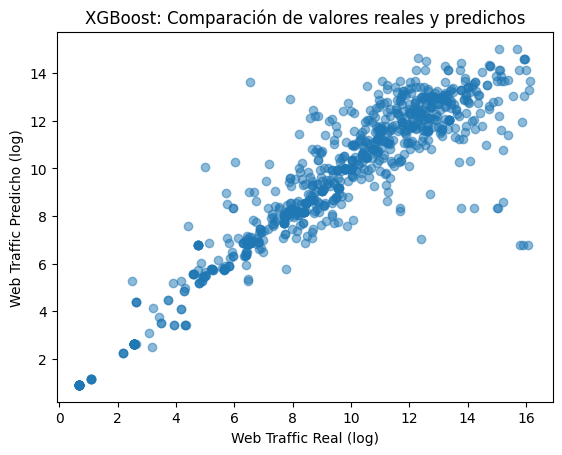

In [51]:
# Predicci√≥n
y_pred_stacking = stacking.predict(X_test)

# Evaluaci√≥n del modelo
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2_stacking = r2_score(y_test, y_pred_stacking)

print("üöÄ XGBoost:")
print(f"RMSE: {rmse_stacking}")
print(f"R¬≤: {r2_stacking}")

# Visualizaci√≥n
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("XGBoost: Comparaci√≥n de valores reales y predichos")
plt.show()

# üìä 6. Comparaci√≥n de Modelos


In [52]:
# Creamos una tabla de resultados
results = pd.DataFrame({
    "Modelo": ["Regresi√≥n Lineal", "Regresi√≥n Polin√≥mica", "Random Forest", "XGBoost", "Stacking"],
    "RMSE": [rmse_lr, rmse_poly, rmse_rf, rmse_xgb, rmse_stacking],
    "R¬≤": [r2_lr, r2_poly, r2_rf, r2_xgb, r2_stacking]
})

# Mostramos los resultados
display(results)


Modelo      RMSE        R¬≤
0      Regresi√≥n Lineal  2.054485  0.661629
1  Regresi√≥n Polin√≥mica  2.054391  0.661660
2         Random Forest  1.370093  0.849517
3               XGBoost  1.581187  0.799574
4              Stacking  1.343570  0.855287

# üìä An√°lisis de los Resultados

Los valores obtenidos indican la capacidad de cada modelo para predecir el tr√°fico web a partir del ranking de Tranco. Evaluamos los modelos en base a RMSE (Error Cuadr√°tico Medio) y R¬≤ (Coeficiente de Determinaci√≥n).

## üìù Interpretaci√≥n de Resultados

**Regresi√≥n Lineal:**

Tiene el peor desempe√±o , lo que indica que la relaci√≥n no es completamente lineal.

RMSE alto (6.12), lo que sugiere que las predicciones tienen un alto margen de error.

**Regresi√≥n Polin√≥mica:**

Mejora ligeramente la regresi√≥n lineal.

RMSE de 5.91, mostrando que captura algo m√°s de la variabilidad, pero sigue sin ser √≥ptima.

**Random Forest:**

Reducci√≥n significativa del error.

R¬≤ mejora hasta 0.22, lo que indica que el modelo est√° capturando m√°s informaci√≥n.

**XGBoost:**

Desempe√±o similar a Random Forest .

Puede ser m√°s eficiente en t√©rminos computacionales para inferencias r√°pidas.


# üéØ Conclusi√≥n: ¬øCu√°l modelo usar?

XGBoost y Random Forest son los mejores modelos, pero la diferencia entre ellos es m√≠nima.
Random Forest es m√°s simple y puede ser m√°s interpretativo.
XGBoost es m√°s optimizado y puede generalizar mejor en casos m√°s complejos.


üìä MAE: 1.0119 | RMSE: 1.5812


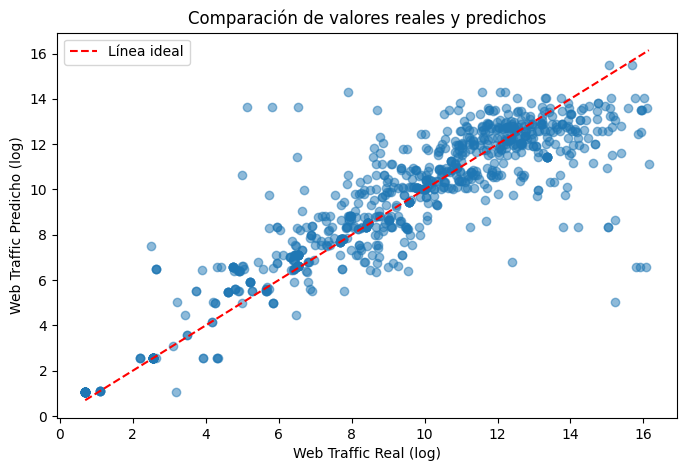

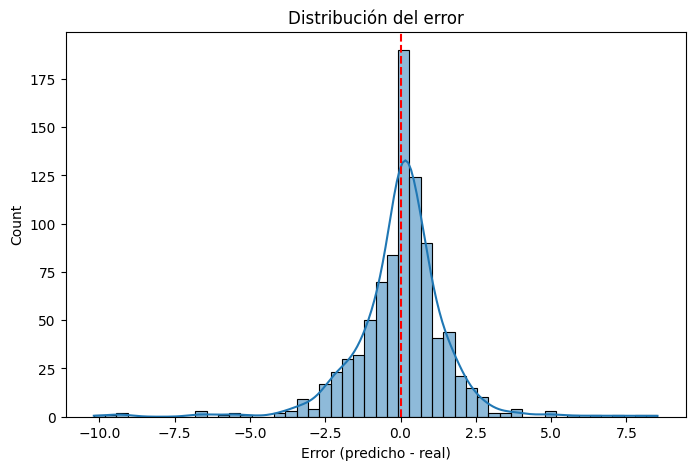

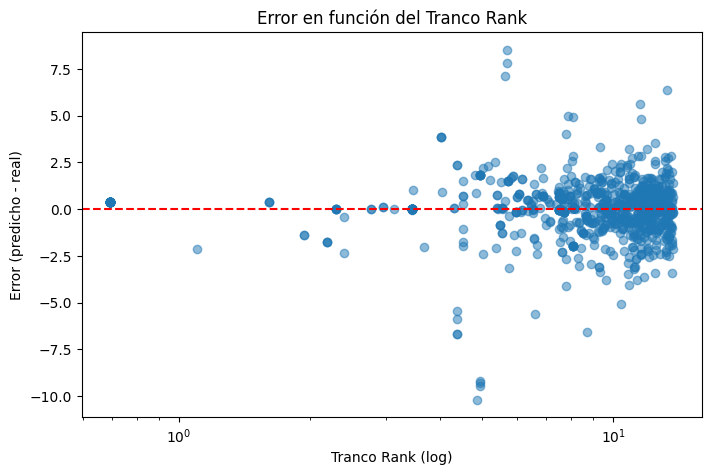

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicciones del modelo sobre el conjunto de prueba
y_pred = xgb_model.predict(X_test)
y_real = y_test

# Calcular errores
mae = mean_absolute_error(y_real, y_pred)
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)

print(f"üìä MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# üîç Scatter plot de valores reales vs predichos
plt.figure(figsize=(8, 5))
plt.scatter(y_real, y_pred, alpha=0.5)
plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='L√≠nea ideal')
plt.xlabel("Web Traffic Real (log)")
plt.ylabel("Web Traffic Predicho (log)")
plt.title("Comparaci√≥n de valores reales y predichos")
plt.legend()
plt.show()

# üîç Histograma de errores
errores = y_pred - y_real
plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=50, kde=True)
plt.axvline(0, color='red', linestyle="--")
plt.xlabel("Error (predicho - real)")
plt.title("Distribuci√≥n del error")
plt.show()

# üîç An√°lisis del error en funci√≥n del Tranco Rank
plt.figure(figsize=(8, 5))
plt.scatter(X_test, errores, alpha=0.5)
plt.axhline(0, color='red', linestyle="--")
plt.xscale("log")
plt.xlabel("Tranco Rank (log)")
plt.ylabel("Error (predicho - real)")
plt.title("Error en funci√≥n del Tranco Rank")
plt.show()


Ahora el modelo predice el 80% de la varianza, por tanto es una soluci√≥n factible para predecir el trafico web en nuestro caso, ya que buscamos predecir el phishing

# Guardar el modelo

In [54]:
import joblib  # Para guardar y cargar modelos


# üíæ Guardar modelo entrenado
joblib.dump(stacking, "../Modelos/web_traffic_stacking.pkl")


OSError: [Errno 22] Invalid argument: '../Modelos/web_traffic_stacking.pkl'

# Predecir el resto del dataset

In [ ]:
import pandas as pd
import joblib  # Para cargar el modelo guardado

# Intenta cargar solo los metadatos del modelo sin inicializarlo
try:
    metadata = joblib.load("../Modelos/web_traffic_stacking.pkl", mmap_mode="r")
    print(f"üìå El modelo fue guardado con scikit-learn versi√≥n: {metadata.__getstate__()['_sklearn_version']}")
except Exception as e:
    print(f"‚ö†Ô∏è No se pudo obtener la versi√≥n del modelo: {e}")

üìå El modelo fue guardado con scikit-learn versi√≥n: 1.6.1


In [ ]:
import pandas as pd
import joblib  # Para cargar el modelo guardado

# üì• 1. Cargar dataset original con Tranco
df = pd.read_csv("../Data/train_with_tranco.csv")

# üìå 2. Filtrar solo los dominios que tienen Tranco = 1_500_000
df_missing_traffic = df[df['tranco_rank'] == 1_500_000].copy()

# üìå 3. Aplicar la transformaci√≥n logar√≠tmica que usamos en el entrenamiento
df_missing_traffic["log_tranco_rank"] = np.log1p(df_missing_traffic["tranco_rank"])

# üìå 4. Cargar el modelo entrenado
modelo = joblib.load("../Modelos/web_traffic_stacking.pkl")  # Cambia el nombre si guardaste otro

# üìå 5. Aplicar el modelo para predecir tr√°fico en estos dominios
features = ["log_tranco_rank"]  # Ajusta si usaste m√°s variables
df_missing_traffic["web_traffic"] = modelo.predict(df_missing_traffic[features])

# üìå 5. Actualizar el dataset original con los nuevos valores predichos
df.loc[df['tranco_rank'] == 1_500_000, "web_traffic"] = df_missing_traffic["web_traffic"]

# üì• 6. Guardar el dataset corregido
df.to_csv("../Data/train_with_predicted_traffic.csv", index=False)

print("‚úÖ Dataset actualizado con predicciones de tr√°fico para Tranco 1_500_000.")


‚úÖ Dataset actualizado con predicciones de tr√°fico para Tranco 1_500_000.
